# Chapter 6: Multiple Linear Regression

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

In [52]:
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
import matplotlib.pylab as plt

import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

%matplotlib inline


In [53]:
pip install dmba

Note: you may need to restart the kernel to use updated packages.


## Table 6.3

In [54]:

car_df = dmba.load_data('ToyotaCorolla.csv')

predictors = ['Age_08_04', 'KM', 'Fuel_Type', 'HP', 'Automatic', 'Doors', 'Quarterly_Tax', 'Mfr_Guarantee', 'Guarantee_Period', 'Airco', 'Automatic_airco', 'CD_Player', 'Powered_Windows', 'Sport_Model','Tow_Bar']
outcome = 'Price'

# partition data
X = pd.get_dummies(car_df[predictors], drop_first=True)
y = car_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.2, random_state=1)

car_lm = LinearRegression()
car_lm.fit(train_X, train_y)

# print coefficients
print('intercept ', car_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': car_lm.coef_}))

# print performance measures
regressionSummary(train_y, car_lm.predict(train_X))

intercept  9069.847844083171
           Predictor  coefficient
0          Age_08_04  -109.758421
1                 KM    -0.018441
2                 HP    37.803435
3          Automatic   617.139156
4              Doors   144.384691
5      Quarterly_Tax    16.624936
6      Mfr_Guarantee   152.904242
7   Guarantee_Period    84.352082
8              Airco   145.472000
9    Automatic_airco  2997.221195
10         CD_Player   284.677044
11   Powered_Windows   462.393436
12       Sport_Model   391.596482
13           Tow_Bar  -221.049096
14  Fuel_Type_Diesel  2160.912503
15  Fuel_Type_Petrol  2154.276224

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1206.8732
            Mean Absolute Error (MAE) : 908.3384
          Mean Percentage Error (MPE) : -0.9840
Mean Absolute Percentage Error (MAPE) : 8.9836


In [55]:
pred_y = car_lm.predict(train_X)

print('adjusted r2 : ', adjusted_r2_score(train_y, pred_y, car_lm))
print('AIC : ', AIC_score(train_y, pred_y, car_lm))
print('BIC : ', BIC_score(train_y, pred_y, car_lm))

adjusted r2 :  0.8855698263332518
AIC :  19585.812410144987
BIC :  19676.63638852882


## Table 6.4

In [56]:
# Use predict() to make predictions on a new set
car_lm_pred = car_lm.predict(valid_X)

result = pd.DataFrame({'Predicted': car_lm_pred, 'Actual': valid_y,
                       'Residual': valid_y - car_lm_pred})
print(result.head(20))

# Compute common accuracy measures
regressionSummary(valid_y, car_lm_pred)

         Predicted  Actual     Residual
509   12139.983555   10900 -1239.983555
435   10634.749072   10895   260.250928
321   13821.969212   10750 -3071.969212
1055   7125.758512    6500  -625.758512
288   11850.911653   11895    44.088347
48    16904.277015   17950  1045.722985
1403   7422.838756    7000  -422.838756
952    9585.771290    8400 -1185.771290
1097   7969.258257    7250  -719.258257
204   11973.507460   12950   976.492540
978    9630.746813    8745  -885.746813
404    9667.336272    9450  -217.336272
1338   7505.525275    7499    -6.525275
754    9150.453002    9950   799.546998
1189   6864.547340    8500  1635.452660
948    7867.625863    7750  -117.625863
1079   5372.381142    8950  3577.618858
1108   8091.566648    8250   158.433352
107   16377.131162   17450  1072.868838
1065   5765.094249    6550   784.905751

Regression statistics

                      Mean Error (ME) : 139.5125
       Root Mean Squared Error (RMSE) : 1217.9176
            Mean Absolute Error (MAE)

## Figure 6.1
Determine the residuals and create a histogram

0.8194444444444444


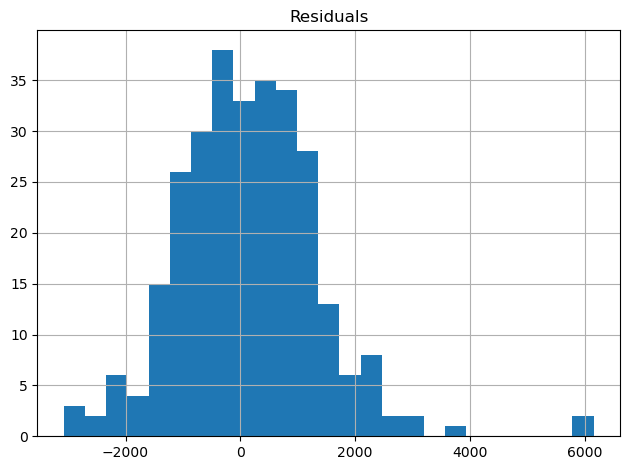

In [57]:
car_lm_pred = car_lm.predict(valid_X)
all_residuals = valid_y - car_lm_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

## Table 6.5
Run an exhaustive search. The Fuel type column is categorical and needs to be converted into dummy variables.

In [58]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.set_option('display.width', 100)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))))
pd.reset_option('display.width')

     n     r2adj           AIC  Age_08_04  Airco  Automatic  Automatic_airco  CD_Player  Doors  \
0    1  0.760594  20418.386406       True  False      False            False      False  False   
1    2  0.816385  20114.800691       True  False      False             True      False  False   
2    3  0.840086  19957.137265       True  False      False             True      False  False   
3    4  0.850538  19880.529661       True  False      False             True      False  False   
4    5  0.868531  19734.269639       True  False      False             True      False  False   
5    6  0.873156  19694.156864       True  False      False             True      False  False   
6    7  0.875677  19672.104620       True  False      False             True      False  False   
7    8  0.877733  19653.950690       True  False      False             True      False  False   
8    9  0.879558  19637.673936       True  False      False             True      False  False   
9   10  0.881221  19

## Table 6.6 backward elimination

In [59]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = backward_elimination(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: Age_08_04, KM, HP, Automatic, Doors, Quarterly_Tax, Mfr_Guarantee, Guarantee_Period, Airco, Automatic_airco, CD_Player, Powered_Windows, Sport_Model, Tow_Bar, Fuel_Type_Diesel, Fuel_Type_Petrol
Start: score=19585.81
Step: score=19585.81, remove None
['Age_08_04', 'KM', 'HP', 'Automatic', 'Doors', 'Quarterly_Tax', 'Mfr_Guarantee', 'Guarantee_Period', 'Airco', 'Automatic_airco', 'CD_Player', 'Powered_Windows', 'Sport_Model', 'Tow_Bar', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol']


In [60]:
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))


Regression statistics

                      Mean Error (ME) : 139.5125
       Root Mean Squared Error (RMSE) : 1217.9176
            Mean Absolute Error (MAE) : 921.5922
          Mean Percentage Error (MPE) : 0.4924
Mean Absolute Percentage Error (MAPE) : 9.1091


## Table 6.7 Forward selection

In [61]:
# The initial model is the constant model - this requires special handling
# in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = forward_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: Age_08_04, KM, HP, Automatic, Doors, Quarterly_Tax, Mfr_Guarantee, Guarantee_Period, Airco, Automatic_airco, CD_Player, Powered_Windows, Sport_Model, Tow_Bar, Fuel_Type_Diesel, Fuel_Type_Petrol
Start: score=22058.56, constant
Step: score=20418.39, add Age_08_04
Step: score=20114.80, add Automatic_airco
Step: score=19957.14, add HP
Step: score=19880.53, add KM
Step: score=19734.27, add Quarterly_Tax
Step: score=19694.16, add Powered_Windows
Step: score=19672.10, add Guarantee_Period
Step: score=19653.95, add Sport_Model
Step: score=19642.51, add Doors
Step: score=19631.52, add Automatic
Step: score=19626.59, add CD_Player
Step: score=19621.55, add Tow_Bar
Step: score=19618.23, add Fuel_Type_Diesel
Step: score=19588.31, add Fuel_Type_Petrol
Step: score=19586.38, add Mfr_Guarantee
Step: score=19585.81, add Airco
Step: score=19585.81, add None
['Age_08_04', 'Automatic_airco', 'HP', 'KM', 'Quarterly_Tax', 'Powered_Windows', 'Guarantee_Period', 'Sport_Model', 'Doors', 'Automatic',

In [62]:
best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: Age_08_04, KM, HP, Automatic, Doors, Quarterly_Tax, Mfr_Guarantee, Guarantee_Period, Airco, Automatic_airco, CD_Player, Powered_Windows, Sport_Model, Tow_Bar, Fuel_Type_Diesel, Fuel_Type_Petrol
Start: score=22058.56, constant
Step: score=20418.39, add Age_08_04
Step: score=20114.80, add Automatic_airco
Step: score=19957.14, add HP
Step: score=19880.53, add KM
Step: score=19734.27, add Quarterly_Tax
Step: score=19694.16, add Powered_Windows
Step: score=19672.10, add Guarantee_Period
Step: score=19653.95, add Sport_Model
Step: score=19642.51, add Doors
Step: score=19631.52, add Automatic
Step: score=19626.59, add CD_Player
Step: score=19621.55, add Tow_Bar
Step: score=19618.23, add Fuel_Type_Diesel
Step: score=19588.31, add Fuel_Type_Petrol
Step: score=19586.38, add Mfr_Guarantee
Step: score=19585.81, add Airco
Step: score=19585.81, unchanged None
['Age_08_04', 'Automatic_airco', 'HP', 'KM', 'Quarterly_Tax', 'Powered_Windows', 'Guarantee_Period', 'Sport_Model', 'Doors', 'Autom

## Table XX regularized methods

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

lasso = Pipeline([
    ['normalize', StandardScaler()],
    ['model', Lasso(alpha=1)],
])
lasso.fit(train_X, train_y)
regressionSummary(valid_y, lasso.predict(valid_X))

lasso_cv = Pipeline([
    ['normalize', StandardScaler()],
    ['model', LassoCV(cv=5)],
])
lasso_cv.fit(train_X, train_y)
regressionSummary(valid_y, lasso_cv.predict(valid_X))
print('Lasso-CV chosen regularization: ', lasso_cv['model'].alpha_)
print(lasso_cv['model'].coef_)

ridge = Pipeline([
    ['normalize', StandardScaler()],
    ['model', Ridge(alpha=1)],
])
ridge.fit(train_X, train_y)
regressionSummary(valid_y, ridge.predict(valid_X))

bayesianRidge = Pipeline([
    ['normalize', StandardScaler()],
    ['model', BayesianRidge()],
])
bayesianRidge.fit(train_X, train_y)
regressionSummary(valid_y, bayesianRidge.predict(valid_X))
print('Bayesian ridge chosen regularization: ', 
      bayesianRidge['model'].lambda_ / bayesianRidge['model'].alpha_)


Regression statistics

                      Mean Error (ME) : 139.6699
       Root Mean Squared Error (RMSE) : 1217.0966
            Mean Absolute Error (MAE) : 920.8167
          Mean Percentage Error (MPE) : 0.4866
Mean Absolute Percentage Error (MAPE) : 9.0969

Regression statistics

                      Mean Error (ME) : 140.0058
       Root Mean Squared Error (RMSE) : 1215.5313
            Mean Absolute Error (MAE) : 919.4862
          Mean Percentage Error (MPE) : 0.4743
Mean Absolute Percentage Error (MAPE) : 9.0770
Lasso-CV chosen regularization:  3.133847165702745
[-2027.75112406  -684.1981925    556.07359425   138.0016273
   135.42279227   650.34730691    73.24931997   234.05061493
    72.55036354   703.18383079   114.42391201   227.40266513
   176.54384513   -95.59843838   592.60963568   611.04671666]

Regression statistics

                      Mean Error (ME) : 139.5273
       Root Mean Squared Error (RMSE) : 1217.4205
            Mean Absolute Error (MAE) : 921.1654
 

In [64]:
linearRegression = Pipeline([
    ['normalize', StandardScaler()],
    ['model', LinearRegression()],
])
linearRegression.fit(train_X, train_y)
regressionSummary(valid_y, linearRegression.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 139.5125
       Root Mean Squared Error (RMSE) : 1217.9176
            Mean Absolute Error (MAE) : 921.5922
          Mean Percentage Error (MPE) : 0.4924
Mean Absolute Percentage Error (MAPE) : 9.1091


In [65]:
pd.DataFrame({
    'features': train_X.columns, 
    'linear regression': linearRegression['model'].coef_, 
    'lassoCV': lasso_cv['model'].coef_, 
    'bayesianRidge': bayesianRidge['model'].coef_,
})

,features,linear regression,lassoCV,bayesianRidge
0,Age_08_04,-2023.958423,-2027.751124,-2013.019192
1,KM,-683.846911,-684.198193,-688.562883
2,HP,561.039247,556.073594,558.517572
3,Automatic,141.594323,138.001627,140.535846
4,Doors,137.196511,135.422792,138.690127
5,Quarterly_Tax,667.652567,650.347307,657.018610
6,Mfr_Guarantee,75.112055,73.249320,76.516670
7,Guarantee_Period,239.777840,234.050615,239.370740
8,Airco,72.691834,72.550364,75.910283
9,Automatic_airco,702.630755,703.183831,703.654119


## Table 6.10

In [66]:
# run a linear regression of Price on the remaining 11 predictors in the training set
train_df = train_X.join(train_y)

predictors = train_X.columns
formula = 'Price ~ ' + ' + '.join(predictors)

car_lm = sm.ols(formula=formula, data=train_df).fit()
print(car_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     555.8
Date:                Wed, 22 May 2024   Prob (F-statistic):               0.00
Time:                        21:19:00   Log-Likelihood:                -9774.9
No. Observations:                1148   AIC:                         1.958e+04
Df Residuals:                    1131   BIC:                         1.967e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               